In [ ]:
!pip install -q remotezip tqdm opencv-python==4.5.2.52 opencv-python-headless==4.5.2.52 tf-models-official

In [ ]:
import tqdm
import random
import pathlib
import itertools
import collections
import glob
from pathlib import Path
import os

import cv2
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
#import tensorflow_docs
#from tensorflow_docs.vis import embed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Import the MoViNet model from TensorFlow Models (tf-models-official) for the MoViNet model
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## TensorFlow DataPipeline

In [ ]:
class FrameGenerator:
    def __init__(self, path, n_frames, training = False):
        """ 
        Returns a set of frames with their associated label. 

        Args:
            path: Video file paths.
            n_frames: Number of frames. 
            training: Boolean to determine if training dataset is being created.
        """
        self.path = path
        self.n_frames = n_frames
        self.training = training
        self.class_names = sorted([str(f).split('/')[4] for f in path.glob('*/') if f.is_dir()])
        self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

    def get_files_and_class_names(self):
        video_paths = list(self.path.glob('*/*.mp4'))
        classes = [p.parent.name for p in video_paths]
        return video_paths, classes

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()
        pairs = list(zip(video_paths, classes))

        if self.training:
            random.shuffle(pairs)

        for path, name in pairs:
            video_frames = frames_from_video_file(path, self.n_frames, augment = True)
            label = self.class_ids_for_name[name] # Encode labels

            yield video_frames, label

In [ ]:
from pathlib import Path
train_path = "drive/MyDrive/Data/Train/"
train_path = Path(train_path)
val_path = "drive/MyDrive/Data/Val/"
val_path = Path(val_path)
test_path = "drive/MyDrive/Data/Test/"
test_path = Path(test_path)

In [ ]:
# Test on FrameGenerator before wrapping it as a TensorFlow Dataset object.

fg = FrameGenerator(train_path, 16, training=True)

frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (10, 224, 224, 3)
Label: 5


In [ ]:
fg.class_ids_for_name

{'GarlandPose': 0,
 'HappyBabyPose': 1,
 'HeadToKnee': 2,
 'LungePose': 3,
 'MountainPose': 4,
 'PlankPose': 5,
 'RaisedArmPose': 6,
 'SeatedForwardBend': 7,
 'StaffPose': 8,
 'StandingForwardBend': 9}

In [ ]:
batch_size = 8
num_frames = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(train_path, num_frames, training = True),
                                          output_signature = output_signature)
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(val_path, num_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(test_path, num_frames),
                                         output_signature = output_signature)
test_ds = test_ds.batch(batch_size)

In [ ]:
# Checking if the data is properly shuffled
for frames, labels in train_ds.take(1):
    print(labels)

tf.Tensor([4 3 5 6 4 4 6 4], shape=(8,), dtype=int16)


In [ ]:
# Checking the shape of the data
print(f"Shape: {frames.shape}")
print(f"Label: {labels.shape}")

Shape: (8, 8, 224, 224, 3)
Label: (8,)


## Download Pre-trained MoViNet Model

In [ ]:
# MoViNet A0

model_id = 'a0'
resolution = 224

tf.keras.backend.clear_session()

backbone = movinet.Movinet(model_id = model_id)
backbone.trainable = False

# Set num_classes = 600 to load the pre-trained weights from the original model
model = movinet_model.MovinetClassifier(backbone = backbone, num_classes = 600)

model.build([None, None, None, None, 3])

# Loading the pre-trained weights
!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_base.tar.gz -O movinet_a0_base.tar.gz -q
!tar -xvf movinet_a0_base.tar.gz

movinet_a0_base/
movinet_a0_base/checkpoint
movinet_a0_base/ckpt-1.data-00000-of-00001
movinet_a0_base/ckpt-1.index


In [ ]:
#MoViNet A1

model_id = 'a1'
resolution = 224

tf.keras.backend.clear_session()

backbone = movinet.Movinet(model_id = model_id)
backbone.trainable = False

# Set num_classes = 600 to load the pre-trained weights from the original model
model = movinet_model.MovinetClassifier(backbone = backbone, num_classes = 600)

model.build([None, None, None, None, 3])

# Loading the pre-trained weights
!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a1_base.tar.gz -O movinet_a1_base.tar.gz -q
!tar -xvf movinet_a1_base.tar.gz

movinet_a1_base/
movinet_a1_base/checkpoint
movinet_a1_base/ckpt-1.data-00000-of-00001
movinet_a1_base/ckpt-1.index


In [ ]:
#MoViNet A2

model_id = 'a2'
resolution = 224

tf.keras.backend.clear_session()

backbone = movinet.Movinet(model_id = model_id)
backbone.trainable = False

# Set num_classes = 600 to load the pre-trained weights from the original model
model = movinet_model.MovinetClassifier(backbone = backbone, num_classes = 600)

model.build([None, None, None, None, 3])

# Loading the pre-trained weights
!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a2_base.tar.gz -O movinet_a2_base.tar.gz -q
!tar -xvf movinet_a2_base.tar.gz

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.1,
                              mode = 'min',
                              patience = 3,
                              verbose = 1)

callbacks = [reduce_lr]
                              verbose = 1)

callbacks = [reduce_lr]

In [ ]:
checkpoint_dir = f'movinet_{model_id}_base'
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint = tf.train.Checkpoint(model = model)
status = checkpoint.restore(checkpoint_path)
status.assert_existing_objects_matched()

In [ ]:
def build_classifier(batch_size, num_frames, resolution, backbone, num_classes):
    
    """Builds a classifier on top of a backbone model."""
    
    model = movinet_model.MovinetClassifier(
    backbone=backbone,
    num_classes=num_classes)
    model.build([batch_size, num_frames, resolution, resolution, 3])

    return model

In [ ]:
model = build_classifier(batch_size, num_frames, resolution, backbone, 10)

In [ ]:
num_epochs = 20

loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

model.compile(loss = loss_obj, optimizer = optimizer, metrics = ['accuracy'])

In [ ]:
results = model.fit(train_ds,
                    validation_data = val_ds,
                    epochs = num_epochs,
                    validation_freq = 1,
                    verbose = 1,
                    callbacks = callbacks
                    )

Epoch 1/20
26/26 [==============================] - 740s 28s/step - loss: 2.2209 - accuracy: 0.1635 - val_loss: 2.1465 - val_accuracy: 0.1923
Epoch 2/20
26/26 [==============================] - 640s 25s/step - loss: 1.6522 - accuracy: 0.4567 - val_loss: 1.7073 - val_accuracy: 0.4615
Epoch 3/20
26/26 [==============================] - 623s 24s/step - loss: 1.3263 - accuracy: 0.5288 - val_loss: 1.7602 - val_accuracy: 0.3846
Epoch 4/20
26/26 [==============================] - 639s 25s/step - loss: 1.0970 - accuracy: 0.6923 - val_loss: 1.9350 - val_accuracy: 0.2692
Epoch 5/20
26/26 [==============================] - 644s 25s/step - loss: 0.9099 - accuracy: 0.7308 - val_loss: 1.4532 - val_accuracy: 0.4231
Epoch 6/20
26/26 [==============================] - 661s 26s/step - loss: 0.8865 - accuracy: 0.6827 - val_loss: 1.6557 - val_accuracy: 0.4231
Epoch 7/20
26/26 [==============================] - 638s 25s/step - loss: 0.8209 - accuracy: 0.7356 - val_loss: 1.1587 - val_accuracy: 0.4615
Epoch 

## Evaluate the Model

In [ ]:
model.evaluate(test_ds, return_dict = True)

4/4 [==============================] - 82s 21s/step - loss: 1.4635 - accuracy: 0.5185


{'loss': 1.4634531736373901, 'accuracy': 0.5185185074806213}

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
train_acc  = [0.1827, 0.4904, 0.5913, 0.6490, 0.6923, 0.7163, 0.6827, 0.7644, 0.7837, 0.7740]
val_acc    = [0.2692, 0.3462, 0.4615, 0.5000, 0.3846, 0.5769, 0.4615, 0.5769, 0.6154, 0.5000]

train_loss = [2.2559, 1.6562, 1.3152, 1.0585, 0.9436, 0.8613, 0.8738, 0.7303, 0.6330, 0.6788]
val_loss   = [1.9886, 1.7271, 1.5868, 1.3282, 1.2889, 1.3792, 1.4785, 1.2785, 1.1867, 1.4094]

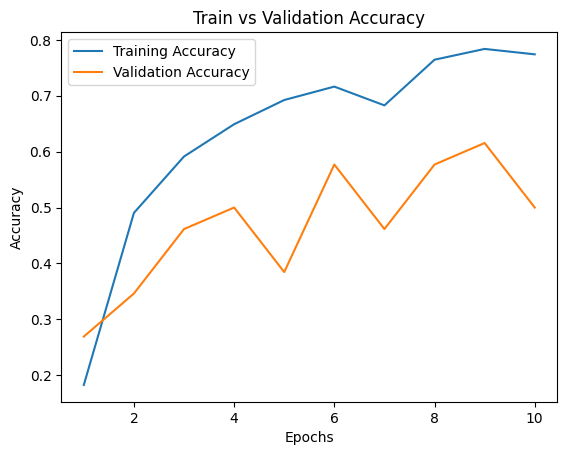

In [ ]:
x_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# Create a lineplot with two lines
ax1 = sns.lineplot(x=x_values, y=train_acc, label='Training Accuracy')
ax2 = sns.lineplot(x=x_values, y=val_acc, label='Validation Accuracy')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')

# Add legend
plt.legend()

# Show the plot
plt.show()

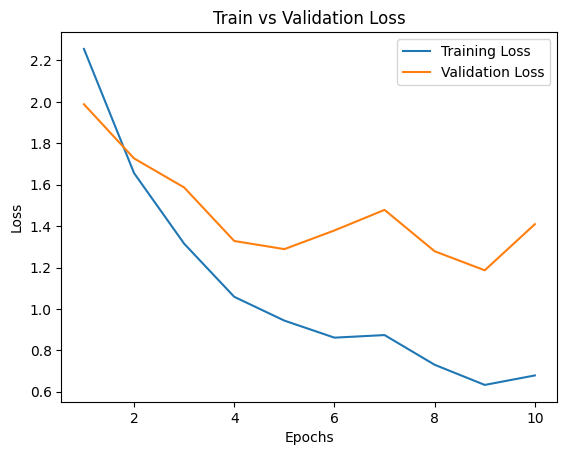

In [ ]:
x_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# Create a lineplot with two lines
ax1 = sns.lineplot(x=x_values, y=train_loss, label='Training Loss')
ax2 = sns.lineplot(x=x_values, y=val_loss, label='Validation Loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Plotting Confusion Matrix to access the performance of the classification model

def get_actual_predicted_labels(dataset):
    """
    Create a list of actual ground truth values and the predictions from the model.
    
    Args:
        dataset : An iterable data structure, such as TensorFlow Dataset, with features and labels.
    
    Return:
        Ground Trugh and the predcited values for a particular dataset
    """
    actual = [labels for _, labels in dataset.unbatch()]
    predicted = model.predict(dataset)
    
    actual = tf.stack(actual, axis = 0)
    predicted = tf.concat(predicted, axis = 0)
    predicted = tf.argmax(predicted, axis = 1)
    
    return actual, predicted

In [ ]:
# Plotting Confusion Matrix to access the performance of the classification model

def get_actual_predicted_labels(dataset):
    """
    Create a list of actual ground truth values and the predictions from the model.
    
    Args:
        dataset : An iterable data structure, such as TensorFlow Dataset, with features and labels.
    
    Return:
        Ground Trugh and the predcited values for a particular dataset
    """
    actual = [labels for _, labels in dataset.unbatch()]
    predicted = model.predict(dataset)
    
    actual = tf.stack(actual, axis = 0)
    predicted = tf.concat(predicted, axis = 0)
    predicted = tf.argmax(predicted, axis = 1)
    
    return actual, predicted

In [ ]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [ ]:
fg = FrameGenerator(train_path, 10, training = True)
label_names = list(fg.class_ids_for_name.keys())

4/4 [==============================] - 219s 47s/step


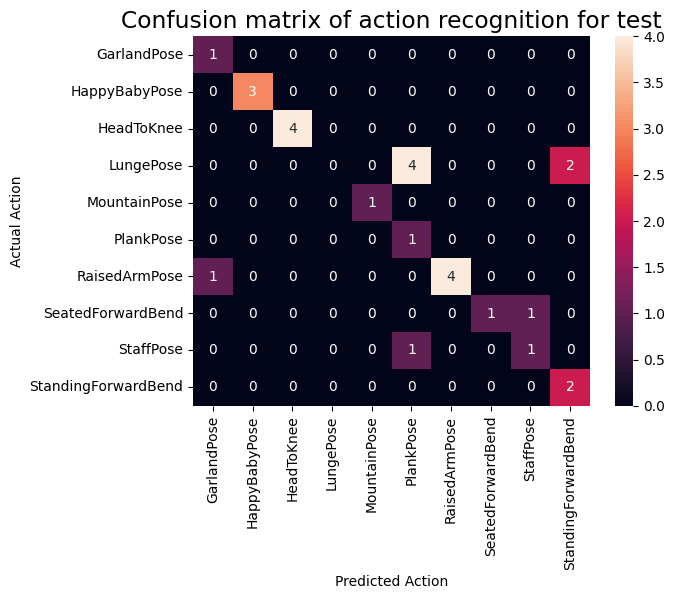

In [ ]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, label_names, 'test')